In [2]:
# Cell 1: Installations, Authentication, and Llama Model Loading
!pip install transformers accelerate bitsandbytes torch datasets scikit-learn matplotlib seaborn umap-learn huggingface_hub

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
from datasets import load_dataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap # umap-learn package
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder # For authentication

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True # Highly recommended for Colab

# --- Hugging Face Token for Llama Models ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login() # This will prompt you to enter your token from https://huggingface.co/settings/tokens
        print("Login successful (or token was already cached and valid).")
    else:
        # Even if a token is found, it might not have the right permissions or be for the right account.
        # Forcing a login or providing a specific token might be needed if issues persist.
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
        # You could add a specific login call here if needed: login("YOUR_HF_TOKEN")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}")
    print("Please ensure you have a valid Hugging Face token with access to Llama 3.")
    raise # Stop execution if login is problematic

Attempting Hugging Face login...
Hugging Face token not found in cache. Please log in when prompted.


Login successful (or token was already cached and valid).


In [4]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: Running on CPU will be very slow. Ensure GPU is enabled in Colab Runtime (Runtime > Change runtime type).")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer for '{MODEL_NAME}' loaded.")

print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None:
             model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))
        if hasattr(model, 'config'):
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

print("initialization done")

Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct' loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
initialization done


In [5]:
#Define Concept and Prepare Data
CONCEPT_NAME = "sentiment"

positive_texts = [
    "This is a wonderful experience and I am very happy.",
    "I love this product, it's absolutely fantastic!",
    "The weather is beautiful today, perfect for a walk.",
    "She gave a truly inspiring and uplifting speech.",
    "What a delightful surprise, it made my day!"
]

negative_texts = [
    "This is a terrible situation and I am very upset.",
    "I hate this product, it's absolutely awful!",
    "The weather is miserable today, dreadful for any activity.",
    "His comments were deeply frustrating and disheartening.",
    "What a horrible incident, it ruined everything."
]

all_texts_for_vc = positive_texts + negative_texts # Renamed to avoid confusion with test_prompts
labels_for_vc = [1] * len(positive_texts) + [0] * len(negative_texts)

print(f"Concept for v_C: {CONCEPT_NAME}")
print(f"Number of positive examples for v_C: {len(positive_texts)}")
print(f"Number of negative examples for v_C: {len(negative_texts)}")

Concept for v_C: sentiment
Number of positive examples for v_C: 5
Number of negative examples for v_C: 5


Targeting module for activations: LlamaDecoderLayer (Last layer in model.model.layers)
Using token aggregation strategy: -1

Concept vector for 'sentiment' calculated. Shape: torch.Size([4096]). Hook removed.


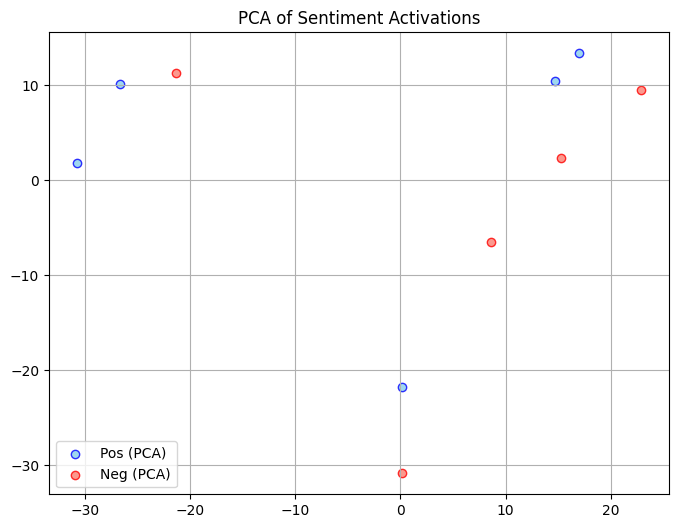


Running t-SNE...


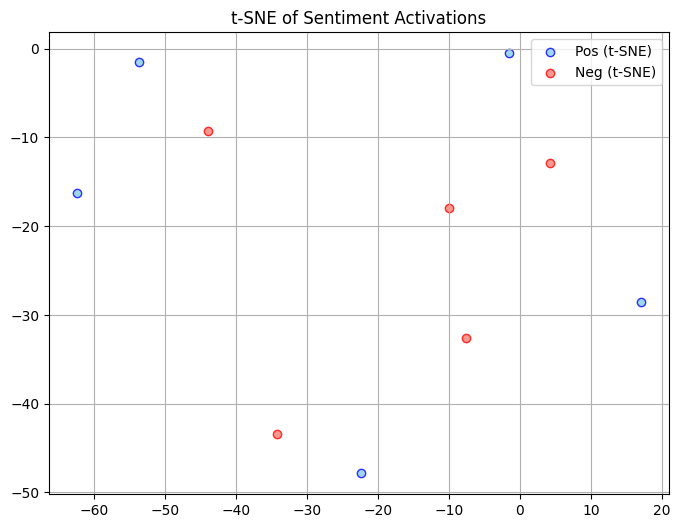

In [6]:
#Activation Extraction, Concept Vector, and Visualizations

activations_storage = {}
def get_activation_hook(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        if isinstance(M_output, tuple):
            activations_storage[layer_name_in_storage] = M_output[0].detach()
        else:
            activations_storage[layer_name_in_storage] = M_output.detach()
    return hook

try:
    target_module_for_activations = model.model.layers[-1]
    hook_storage_name = "last_decoder_block_output"
    print(f"Targeting module for activations: {type(target_module_for_activations).__name__} (Last layer in model.model.layers)")
except AttributeError:
    print("Could not find model.model.layers. Please inspect your model structure.")
    target_module_for_activations = None
    hook_handle = None

if target_module_for_activations:
    hook_handle = target_module_for_activations.register_forward_hook(get_activation_hook(hook_storage_name))
else:
    print("Skipping hook registration as target_module_for_activations is not set.")
    hook_handle = None # Explicitly set to None

def get_activations_for_texts_batch(texts_batch, storage_name, agg_token_strategy=-1):
    inputs = tokenizer(texts_batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        _ = model(**inputs)
    batch_activations = activations_storage.get(storage_name)
    if batch_activations is None:
        raise ValueError(f"Activations not found: {storage_name}. Hook issue?")
    batch_activations = batch_activations.cpu()
    relevant_activations_list = []
    if agg_token_strategy == 'mean':
        relevant_activations = batch_activations.mean(dim=1)
    elif agg_token_strategy == -1 :
        sequence_lengths = inputs.attention_mask.sum(dim=1)
        for i in range(batch_activations.shape[0]):
            last_token_idx = max(0, sequence_lengths[i].item() - 1)
            relevant_activations_list.append(batch_activations[i, last_token_idx, :])
        relevant_activations = torch.stack(relevant_activations_list)
    else:
        relevant_activations = batch_activations[:, agg_token_strategy, :]
    return relevant_activations

concept_vector_sentiment = None # Initialize
if hook_handle:
    token_aggregation_strategy = -1
    print(f"Using token aggregation strategy: {token_aggregation_strategy}")
    positive_activations = get_activations_for_texts_batch(positive_texts, hook_storage_name, token_aggregation_strategy)
    negative_activations = get_activations_for_texts_batch(negative_texts, hook_storage_name, token_aggregation_strategy)
    mean_positive_activation = positive_activations.mean(dim=0)
    mean_negative_activation = negative_activations.mean(dim=0)
    concept_vector_sentiment = mean_positive_activation - mean_negative_activation
    concept_vector_sentiment = concept_vector_sentiment.to(device)
    hook_handle.remove()
    print(f"\nConcept vector for '{CONCEPT_NAME}' calculated. Shape: {concept_vector_sentiment.shape}. Hook removed.")

    # --- CORRECTED Enhanced Visualizations ---
    all_extracted_activations_float32 = torch.cat([positive_activations, negative_activations], dim=0).to(torch.float32)
    all_extracted_activations_numpy = all_extracted_activations_float32.numpy()
    n_positive = len(positive_texts)

    # (Optional for speed tonight: you can comment out some/all visualization plots if needed)
    # 1. PCA
    pca = PCA(n_components=2)
    projected_pca = pca.fit_transform(all_extracted_activations_numpy)
    plt.figure(figsize=(8,6)); plt.scatter(projected_pca[:n_positive,0], projected_pca[:n_positive,1],label="Pos (PCA)",c="skyblue",alpha=0.8,edgecolors='b'); plt.scatter(projected_pca[n_positive:,0], projected_pca[n_positive:,1],label="Neg (PCA)",c="salmon",alpha=0.8,edgecolors='r'); plt.legend(); plt.grid(True); plt.title("PCA of Sentiment Activations"); plt.show()

    # 2. t-SNE
    if all_extracted_activations_numpy.shape[0] > 1: # tSNE/UMAP need more than 1 sample
        print("\nRunning t-SNE..."); tsne = TSNE(n_components=2,random_state=42,perplexity=min(5,all_extracted_activations_numpy.shape[0]-1)); projected_tsne = tsne.fit_transform(all_extracted_activations_numpy); plt.figure(figsize=(8,6)); plt.scatter(projected_tsne[:n_positive,0],projected_tsne[:n_positive,1],label="Pos (t-SNE)",c="skyblue",alpha=0.8,edgecolors='b'); plt.scatter(projected_tsne[n_positive:,0],projected_tsne[n_positive:,1],label="Neg (t-SNE)",c="salmon",alpha=0.8,edgecolors='r'); plt.legend();plt.grid(True); plt.title("t-SNE of Sentiment Activations"); plt.show()

    # # 3. UMAP (Install umap-learn if not already done: !pip install umap-learn)
    # if all_extracted_activations_numpy.shape[0] > 1:
    #     print("\nRunning UMAP..."); n_neighbors_umap = min(5, all_extracted_activations_numpy.shape[0]-1); n_neighbors_umap = max(2, n_neighbors_umap); reducer = umap.UMAP(n_components=2,random_state=42,n_neighbors=n_neighbors_umap,min_dist=0.1); projected_umap = reducer.fit_transform(all_extracted_activations_numpy); plt.figure(figsize=(8,6)); plt.scatter(projected_umap[:n_positive,0],projected_umap[:n_positive,1],label="Pos (UMAP)",c="skyblue",alpha=0.8,edgecolors='b'); plt.scatter(projected_umap[n_positive:,0],projected_umap[n_positive:,1],label="Neg (UMAP)",c="salmon",alpha=0.8,edgecolors='r');plt.legend();plt.grid(True); plt.title("UMAP of Sentiment Activations"); plt.show()

    # # 4. K-Means (Optional for speed)
    # if all_extracted_activations_numpy.shape[0] > 1:
    #     print("\nRunning K-Means..."); kmeans = KMeans(n_clusters=2,random_state=42,n_init='auto'); cluster_labels = kmeans.fit_predict(all_extracted_activations_numpy); plt.figure(figsize=(8,6)); plt.scatter(projected_pca[:,0],projected_pca[:,1],c=cluster_labels,cmap='coolwarm',alpha=0.8); plt.title("K-Means on PCA Projection"); plt.grid(True); plt.show()
else:
    print("Concept vector not calculated due to missing hook or other issues earlier in the cell.")

In [7]:
#Evaluation Setup & Test Prompts

# --- Evaluation Test Set ---
test_prompts_base = [ # Base parts of prompts
    "The report covered several key areas of the project",
    "During the weekly meeting, the team discussed",
    "The system update is scheduled to deploy",
    "Feedback from the initial user testing indicated",
    "Further analysis of the data revealed that" # Added "that" for better completion flow
]

# --- Metric 1: Concept Control Strength (CCS) ---
# Using a pre-trained sentiment classifier
sentiment_classifier_pipe = hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)

def score_concept_control(generated_texts, target_sentiment_label="POSITIVE", target_score_threshold=0.7):
    if not generated_texts: return 0.0
    sentiments = sentiment_classifier_pipe(generated_texts)
    controlled_count = 0
    for text_idx, result in enumerate(sentiments):
        # print(f"CCS Eval: '{generated_texts[text_idx]}' -> {result}") # Debug
        if result['label'].upper() == target_sentiment_label.upper() and result['score'] > target_score_threshold:
            controlled_count += 1
    return (controlled_count / len(generated_texts)) * 100

# --- Metric 2: Fluency/Quality - Perplexity (PPL) ---
# Using GPT-2 as the external model for PPL calculation
ppl_model_name = "gpt2" # Smaller model for faster PPL
print(f"Loading PPL model: {ppl_model_name}...")
ppl_tokenizer = AutoTokenizer.from_pretrained(ppl_model_name)
ppl_model = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
if ppl_tokenizer.pad_token is None: # GPT-2 often needs pad token set
    ppl_tokenizer.pad_token = ppl_tokenizer.eos_token
print(f"PPL model '{ppl_model_name}' loaded.")

def calculate_perplexity(texts_list):
    if not texts_list: return float('inf')
    total_neg_log_likelihood = 0
    total_tokens = 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        encodings = ppl_tokenizer(text_item, return_tensors="pt", padding=True, truncation=True, max_length=ppl_tokenizer.model_max_length).to(device)
        input_ids = encodings.input_ids
        if input_ids.numel() == 0 or input_ids.size(1) == 0: continue

        with torch.no_grad():
            outputs = ppl_model(input_ids, labels=input_ids) # Pass labels for loss calculation
        # outputs.loss is already the mean negative log likelihood per token for this sample
        total_neg_log_likelihood += outputs.loss.item() * input_ids.size(1) # Multiply by num tokens to get sum
        total_tokens += input_ids.size(1)

    if total_tokens == 0: return float('inf')
    avg_neg_log_likelihood = total_neg_log_likelihood / total_tokens
    perplexity = torch.exp(torch.tensor(avg_neg_log_likelihood)).item()
    return perplexity

print("Evaluation functions (score_concept_control, calculate_perplexity) and test_prompts_base are defined.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Loading PPL model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PPL model 'gpt2' loaded.
Evaluation functions (score_concept_control, calculate_perplexity) and test_prompts_base are defined.


In [9]:
#Steering Experiment & Baseline Evaluation (Iteration 0)

if 'concept_vector_sentiment' not in globals() or concept_vector_sentiment is None:
    print("ERROR: `concept_vector_sentiment` is not defined. Please ensure Cell 3 ran successfully and calculated it.")
    # You might want to stop execution here or handle this case more gracefully
    # For now, we'll let it try to proceed but steering_target_module check will also fail.
else:
    print(f"Using concept_vector_sentiment with shape: {concept_vector_sentiment.shape}")


# --- Steering Configuration ---
steering_alpha_positive = 1.0 # Initial alpha for positive steering
steering_alpha_negative = -1.0 # Initial alpha for negative steering
max_new_gen_tokens = 40 # Max new tokens for generation (increased slightly)
tokenizer_input_max_len = 512 # Max length for tokenizing the input prompt string

modified_activations_storage = {} # For any debugging if needed

def steering_hook_fn(layer_name_in_storage, concept_vector_to_add, alpha_value, steer_token_idx=-1):
    """
    A hook that ADDS the concept_vector_to_add (scaled by alpha_value) to the activations.
    steer_token_idx: -1 to steer only the last token's activation.
                     None to steer all tokens in the current forward pass of the hooked module.
    """
    def hook(module, M_input, M_output):
        # Output of LlamaDecoderLayer is a tuple: (hidden_states, self_attn_weights, past_key_value)
        # We need to modify the hidden_states, which is M_output[0]
        original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
        modified_output_tensor = original_output_tensor.clone()

        # Ensure concept_vector is on the same device as the activations
        cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)

        if steer_token_idx == -1: # Steer only the last token's activation in the current pass
            # This adds the concept vector to the representation of the last token
            # Shape of modified_output_tensor is (batch_size, seq_len, hidden_dim)
            # Shape of cv_on_correct_device is (hidden_dim)
            # We unsqueeze cv_on_correct_device to make it [1, hidden_dim] for broadcasting
            # and add to modified_output_tensor[:, -1, :] which is [batch_size, hidden_dim]
            modified_output_tensor[:, -1, :] = modified_output_tensor[:, -1, :] + (alpha_value * cv_on_correct_device)
        elif steer_token_idx is None: # Steer all tokens in the current pass (can be very disruptive)
            modified_output_tensor = modified_output_tensor + (alpha_value * cv_on_correct_device) # Broadcasting applies
        else: # Steer specific index (less common for this type of broad steering during generation)
             if steer_token_idx < modified_output_tensor.shape[1]: # Check if index is valid
                modified_output_tensor[:, steer_token_idx, :] = \
                    modified_output_tensor[:, steer_token_idx, :] + (alpha_value * cv_on_correct_device)

        # modified_activations_storage[layer_name_in_storage] = original_output_tensor.detach().cpu() # Optional: for debugging

        if isinstance(M_output, tuple):
            # Return the modified hidden_states along with other original outputs (like attention weights, KVs)
            return (modified_output_tensor,) + M_output[1:]
        else:
            return modified_output_tensor
    return hook

# --- Identify target module for steering (should be same as activation extraction) ---
steering_target_module = None # Initialize
steering_layer_name_hook = "last_decoder_block_steering" # Descriptive name for hook storage (if used)

if hasattr(model, 'model') and hasattr(model.model, 'layers') and len(model.model.layers) > 0:
    steering_target_module = model.model.layers[-1] # Target the last decoder layer
    print(f"Steering target module set to: {type(steering_target_module).__name__} (Last Llama Decoder Layer)")
else:
    print("ERROR: Steering target module for Llama (model.model.layers[-1]) not found. Please verify model structure in Cell 1.")
    # print(model) # Uncomment this if you need to inspect the model structure

iteration_results = {} # To store PPL and CCS for each run

def generate_and_evaluate(current_run_name, prompts_base_list,
                          apply_steering=False,
                          concept_vec=None,
                          alpha_val=0,
                          target_sentiment_for_ccs=None):
    """
    Generates texts for a list of base prompts, with optional steering, and evaluates them.
    """
    generated_texts_for_eval = []
    hook_handle_steering = None # Initialize to None

    if apply_steering and steering_target_module and concept_vec is not None:
        # Create and register the hook *only if* steering is applied
        steering_hook_instance = steering_hook_fn(
            steering_layer_name_hook,
            concept_vec,
            alpha_val,
            steer_token_idx=-1 # Steer last token
        )
        hook_handle_steering = steering_target_module.register_forward_hook(steering_hook_instance)
        print(f"\nGenerating texts for '{current_run_name}' with steering (alpha={alpha_val})...")
    else:
        print(f"\nGenerating texts for '{current_run_name}' (no steering / baseline)...")

    for p_base in prompts_base_list:
        # Llama 3 Instruct chat template formatting
        # System prompt can be adjusted if needed, or removed for more "raw" completion
        messages = [
            {"role": "system", "content": "You are a helpful assistant that provides fluent and coherent sentence completions."},
            {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"} # Adjusted prompt for more natural completion
        ]

        # Tokenize the formatted prompt string
        prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(
            prompt_string,
            return_tensors="pt",
            max_length=tokenizer_input_max_len, # Use defined, reasonable max length (FIXED HERE)
            truncation=True
        ).to(device)

        # Ensure input_ids are not empty after tokenization/truncation
        if inputs.input_ids.shape[1] == 0:
            print(f"  Warning: Input for prompt '{p_base[:50]}...' resulted in empty input_ids after tokenization. Skipping.")
            generated_texts_for_eval.append("") # Append empty for error/skip cases
            continue

        try:
            with torch.no_grad(): # Ensure no gradients are calculated during generation
                outputs = model.generate(
                    inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_new_tokens=max_new_gen_tokens,
                    temperature=0.7, # Add some variability
                    do_sample=True,  # Enable sampling
                    pad_token_id=tokenizer.pad_token_id,
                    # For Llama 3, multiple EOS tokens might be relevant. tokenizer.eos_token_id gives one.
                    # You can pass a list: eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")]
                    eos_token_id=tokenizer.eos_token_id
                )

            # Decode the full generated sequence for evaluation
            full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # For display, try to isolate only the newly generated part
            input_length = inputs.input_ids.shape[1]
            newly_generated_ids = outputs[0, input_length:]
            completion_only = tokenizer.decode(newly_generated_ids, skip_special_tokens=True)

            # print(f"  Input: {prompt_string}") # For debugging input
            # print(f"  Full Output: {full_decoded_text}") # For debugging output
            print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'") # Display progress
            generated_texts_for_eval.append(full_decoded_text) # Use full text for sentiment/PPL

        except Exception as e:
            print(f"  Error during generation for prompt '{p_base[:50]}...': {e}")
            generated_texts_for_eval.append("")

    if hook_handle_steering: # Remove hook if it was registered
        hook_handle_steering.remove()
        # print("Steering hook removed after generation.")

    # Evaluate
    current_ppl = calculate_perplexity(generated_texts_for_eval)
    current_ccs = 0.0
    if target_sentiment_for_ccs and generated_texts_for_eval: # Ensure list is not empty
        current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

    # Store and print results
    iteration_results[current_run_name] = {"ppl": current_ppl, "ccs": current_ccs if target_sentiment_for_ccs else "N/A", "outputs": generated_texts_for_eval}
    print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
    if target_sentiment_for_ccs:
        print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
    else:
        print("") # Just newline if no CCS

    return generated_texts_for_eval # Though results are stored globally too

# --- Main Execution for Iteration 0 ---
if steering_target_module and ('concept_vector_sentiment' in globals() and concept_vector_sentiment is not None):
    print("\n--- Iteration 0: Evaluation Run ---")

    # 1. Baseline (No Steering)
    generate_and_evaluate(
        current_run_name="baseline",
        prompts_base_list=test_prompts_base, # Defined in Cell 4
        apply_steering=False
    )

    # 2. Positive Sentiment Steering
    generate_and_evaluate(
        current_run_name=f"positive_steer_alpha_{steering_alpha_positive}",
        prompts_base_list=test_prompts_base,
        apply_steering=True,
        concept_vec=concept_vector_sentiment,
        alpha_val=steering_alpha_positive,
        target_sentiment_for_ccs="POSITIVE"
    )

    # 3. Negative Sentiment Steering
    generate_and_evaluate(
        current_run_name=f"negative_steer_alpha_{steering_alpha_negative}",
        prompts_base_list=test_prompts_base,
        apply_steering=True,
        concept_vec=concept_vector_sentiment,
        alpha_val=steering_alpha_negative,
        target_sentiment_for_ccs="NEGATIVE"
    )

    print("\n--- Iteration 0 Evaluation Complete ---")
    print("\nSummary of Iteration 0 Results:")
    for run_name, metrics in iteration_results.items():
        print(f"  Run: {run_name}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")
        # Optionally print a sample output
        # if metrics.get('outputs') and len(metrics['outputs']) > 0:
        #     print(f"    Sample Output: {metrics['outputs'][0][:150]}...")


else:
    print("Skipping Iteration 0 (Steering Experiment & Baseline Evaluation) due to missing 'steering_target_module' or 'concept_vector_sentiment'.")
    print("Please ensure Cell 1 (model loading) and Cell 3 (concept vector calculation) ran successfully.")

Using concept_vector_sentiment with shape: torch.Size([4096])
Steering target module set to: LlamaDecoderLayer (Last Llama Decoder Layer)

--- Iteration 0: Evaluation Run ---

Generating texts for 'baseline' (no steering / baseline)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'that the project was progressing well and on schedule, with a few minor issues that needed to be add...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: '...that the project was progressing well, but there were still some challenges to be addressed befor...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: '...one of cautious optimism, with the IT team having thoroughly tested the new features and bug fixe...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: '...that the interface was user-friendly and intuitive, with a few minor suggestions for improvement ...'


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Prompt: 'Further analysis of the data revealed that...' -> Completion: '...that the trends and patterns that emerged from the data were both surprising and insightful, and ...'
Results for 'baseline': PPL: 58.31

Generating texts for 'positive_steer_alpha_1.0' with steering (alpha=1.0)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: '...that the project had made significant progress, with the team's hard work and dedication evident ...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: '...that the project was on track to meet the deadline, with some minor adjustments needed to ensure ...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: '...one of anticipation and slight nervousness among the team, as the success of the update would hav...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: '...that the application's user interface needed to be refined and simplified, with